# MSCF 46982 Market Microstructure and Algorithmic Trading

Fall 2025 Mini 2

Optimal Execution

Copyright &copy; 2025 Nick Psaris. All Rights Reserved

# TOC
- [Initialize](#Initialize)
- [Almgren and Chriss (2000) Model](#Almgren-and-Chriss-(2000)-Model)
- [Permanent and Temporary Impact](#Permanent-and-Temporary-Impact)
- [Linear Impact Functions](#Linear-Impact-Functions)
- [Summary of Coefficients](#Summary-of-Coefficients)
- [Minimum Impact and Variance](#Minimum-Impact-and-Variance)
- [Expected Cost and Variance of Optimal Execution](#Expected-Cost-and-Variance-of-Optimal-Execution)
- [Computation of Expected Cost and Variance of Optimal Execution](#Computation-of-Expected-Cost-and-Variance-of-Optimal-Execution)
- [Parameter Selection](#Parameter-Selection)
- [Efficient Frontier](#Efficient-Frontier)
- [Trajectory and Trade List](#Trajectory-and-Trade-List)


# Initialize
- We start by initializing the number of rows and columns displayed

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx


<frozen importlib._bootstrap>:488: PyKXWarning: Unable to connect user QHOME to PyKX QHOME via symlinks.
To permanently disable attempts to create symlinks you can
	1. Set the environment variable "PYKX_IGNORE_QHOME" = True.
	2. Update the file ".pykx-config" using kx.util.add_to_config({'PYKX_IGNORE_QHOME': 'True'})
Error: [WinError 1314] A required privilege is not held by the client: 'C:\\Users\\jacob\\Desktop\\Fin Computing I\\Mkt Micro and Algo\\06. Advanced NYSE Daily TAQ Queries.ipynb' -> 'C:\\Users\\jacob\\Desktop\\Fin Computing I\\env\\Lib\\site-packages\\pykx\\lib\\4-1-libs\\06. Advanced NYSE Daily TAQ Queries.ipynb'



PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


In [2]:
\c 25 120
assert:{if[not x~y;'`$"expecting '",(-3!x),"' but found '",(-3!y),"'"]}

In [3]:
%%py
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]


# Almgren and Chriss (2000)

[Almgren, R. and Chriss, N. (2001)][] Optimal Execution of Portfolio
Transactions. Journal of Risk, 3, 5-40.

[Almgren, R. and Chriss, N. (2001)]: https://doi.org/10.21314/JOR.2001.041 "Almgren and Chriss (2001)"

- **Implementation shortfall** is defined as the combined effect of three costs:
  1. **Temporary Market Impact** - temporary movements away from
    *equilibrium* resulting from changes in supply and demand caused
    by trading activity
  2. **Permanent Market Impact** - changes in the *equilibrium* price
    caused by trading activity
  3. **Risk** - changes in execution price due to random price
    fluctuations

- Prior to execution, implementation shortfall is a random variable
  which can be estimated and minimized
- The optimization process is a trade-off between impact and variance
  (fast execution increases impact and decreases exposure to price
  variance while slow execution has the reverse effect)
- An **efficient frontier** can be built that minimizes total cost for
  a given level of price uncertainty -- these are the optimal trading
  strategies


# Permanent and Temporary Impact
The model assumes prices evolve according to an **arithmetic** random walk

$$
S_k = S_{k-1} + \sigma \tau^{1/2}\xi_k - \tau g\left(\frac{n_k}{\tau}\right)
$$

where $\sigma$ represents the security volatility, $\xi_k$ are draws
from independent random variables (with mean zero and unit variance),
$\tau$ is the time unit, $n_k$ is the number of units traded and
$g(v)$ is the **permanent impact** as a function of the average rate
of trading $n_k/\tau$.

The price obtained by the trader incorporates the **temporary impact**
term $h(v)$ which does not persist to the next price $S_k$.

$$
\tilde{S}_k = S_{k-1} - h\left(\frac{n_k}{\tau}\right)
$$

Taking an expectation over the distribution results in an expected
value and variance.

\begin{align}
E(x) &= \sum_{k=1}^N\tau x_k g\left(\frac{n_k}{\tau}\right) + \sum_{k=1}^N n_k h\left(\frac{n_k}{\tau}\right) \\
V(x) &= \sigma^2 \sum_{k=1}^N\tau x_k^2
\end{align}

Each trader has a different aversion to risk $\lambda$, so our goal is
to minimize $E(x) + \lambda V(x)$ for different values of $\lambda$.


# Linear Impact Functions
Almgren and Chriss demonstrate a linear implementation of $g(v)$
(permanent) and $h(v)$ (temporary) impact terms

\begin{align}
g(v) &= \gamma v \\
h\left(\frac{n_k}{\tau}\right) &= \epsilon \cdot \text{sgn}(n_k) + \frac{\eta}{\tau}n_k
\end{align}

where the three parameters $\gamma$, $\epsilon$ and $\eta$ control the
permanent, time-independent temporary and time-dependent temporary
costs respectively.

Using these linear (with respect to the rate of trading $v$)
functions, we can solve for two extreme solutions: minimum impact and
minimum variance.


# Summary of Coefficients
| coef       | type             | units                   | description                                                        |
| :-:        | -                | :-:                     | -                                                                  |
| $\gamma$   | permanent impact | (\$/share)/share        | time-independent share multiplier                                  |
| $\epsilon$ | fixed cost       | \$/share                | fixed cost of trading (i.e., half bid/ask spread + fees)           |
| $\eta$     | temporary impact | (\$/share)/(share/time) | time-dependent share multiplier (hardest to measure)               |
| $\lambda$  | risk aversion    | 1/\$                    | the cost of an extra square dollar of variance (hard to interpret) |
  

# Minimum Impact and Variance
By executing at a constant rate of $n_k = \frac{X}{N}$ we can achieve
a **minimum impact**.  The longer we take to execute, the smaller the
expected impact, but the greater the variance.

\begin{align}
E &= \tfrac{1}{2}\gamma X^2 + \epsilon X + (\eta - \tfrac{1}{2}\gamma \tau)\frac{X^2}{T} \\
V &= \tfrac{1}{3}\sigma^2X^2T\left(1-\frac{1}{N}\right)\left(1-\frac{1}{2N}\right)
\end{align}

By executing all quantity in the first time slice $\tau$ we achieve
**minimum variance** (zero) at the expense of high impact.  The impact
increases as we shorten the time $\tau$ of execution.

\begin{align}
E &= \epsilon X + \eta \frac{X^2}{\tau} \\
V &= 0
\end{align}

# Expected Cost and Variance of Optimal Execution
Almgren and Chriss solve the following unconstrained problem which is
strictly convex when $\lambda$ is positive and therefore has a single
solution.

$$
\min_x \left(E(x) + \lambda V(x)\right)
$$

where $\lambda$ is the risk-aversion coefficient.

\begin{align}
E(X) &= \tfrac{1}{2}\gamma X^2 + \epsilon X+\tilde{\eta}X^2\frac{\tanh(\tfrac{1}{2}\kappa\tau)\left(\tau\sinh(2\kappa T)+2T\sinh(\kappa\tau)\right)}{2\tau^2\sinh^2(\kappa T)}  \\
V(X) &= \tfrac{1}{2}\sigma^2X^2\frac{\tau\sinh(\kappa T)\cosh\left(\kappa(T-\tau)\right) - T \sinh(\kappa\tau)}{\sinh^2(\kappa T)\sinh(\kappa \tau)}
\end{align}

where $\kappa = \sqrt{\frac{\lambda\sigma^2}{\eta}}$ is the square
root of the ratio of the product of our risk-aversion and the
volatility to the temporary impact cost parameter, and $\tilde{\eta} =
\eta - \tfrac{1}{2}\gamma\tau$.

Varying $k \rightarrow 0,\infty$ results in the minimum impact and
minimum variance solutions presented above.


# Computation of Expected Cost and Variance of Optimal Execution
``q`` does not have native implementations for $sinh$, $cosh$, $tanh$
or the complex math primitives required to implement them. We must
implement these ourselves.


## Hyperbolic Primitives

\begin{align}
\sinh x &= \frac{e^x - e^{-x}}{2} \\
\cosh x &= \frac{e^x + e^{-x}}{2} \\
\tanh x &= \frac{\sinh x}{\cosh x} = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{e^{2x}-1}{e^{2x}+1}
\end{align}


In [4]:
sinh:{.5*exp[x]-exp neg x}
cosh:{.5*exp[x]+exp neg x}
tanh:{(x-1f)%1f+x:exp 2f*x}

## Complex Hyperbolic Primitives

\begin{align}
\sinh(x+iy) &= \sinh x \cos y + i\cosh x\sin y \\
\cosh(x+iy) &= \cosh x \cos y + i\sinh x\sin y \\
\tanh(x+iy) &= \frac{\sinh 2x + i\sin 2y}{\cosh 2x + \cos 2y}
\end{align}


In [5]:
/ complex numbers $x + yi$ are stored as a pairs of values: (x;y)
csinh:{(*/)((sinh;cosh);(cos;sin))@\:'x}
ccosh:{(*/)((cosh;sinh);(cos;sin))@\:'x}
ctanh:{((sinh;sin)@'x)%\:(+/)(cosh;cos)@'x*:2f}

## Complex Primitives

\begin{align}
\sqrt x &= 
\begin{cases} 
\sqrt x +i0 & \text{if } x>=0 \\
0 + i\sqrt{-x}& \text{if } x<0
\end{cases} \\
(a+ib)(c+id) &= (ac-bd)+i(ad+bc) \\
\frac{a+ib}{c+id} &= \frac{(ac+bd)+i(bc-ad)}{c^2 + d^2}
\end{align}

In [6]:
csqrt:{(?[n;0f;sqrt x];?[n:x<0f;sqrt neg x;0f])}
cmul:{((-/)x*y;(+/)x*(|)y)}
cdiv:{((+/)x*y;(-/)y*(|)x)%\:(+/)y*y}

## Expected Cost of Optimal Execution

$$
E = \tfrac{1}{2}\gamma X^2 + \epsilon X + (\eta - \tfrac{1}{2}\gamma \tau)\frac{X^2}{T}
$$

where $\kappa = \sqrt{\frac{\lambda\sigma^2}{\eta}}$ is the square
root of the ratio of the product of our risk-aversion and the
volatility to the temporary impact cost parameter, and $\tilde{\eta} =
\eta - \tfrac{1}{2}\gamma\tau$.


In [7]:
E:{[gam;eps;eta;sig;T;N;X;lam]
 tau:T%N;
 kap:csqrt lam*sig*sig%eta;
 eta-:.5*gam*tau; / adjust eta after computing kappa
 kt:kap*tau; kT:kap*T; / precompute kt and kT
 E:first cmul[ctanh .5*kt] csinh[2f*kT]+2f*T*csinh[kt]; / only real remains
 E:eta*(X2:X*X)*E%(2f*tau*tau)*first cmul . 2#enlist csinh[kT]; / only real remains
 E+:eps*X;
 E+:.5*gam*X2;
 E}

## Expected Risk of Optimal Execution

$$
V(X) = \tfrac{1}{2}\sigma^2X^2\frac{\tau\sinh(\kappa T)\cosh\left(\kappa(T-\tau)\right) - T \sinh(\kappa\tau)}{\sinh^2(\kappa T)\sinh(\kappa \tau)}
$$

where $\kappa = \sqrt{\frac{\lambda\sigma^2}{\eta}}$ is the square
root of the ratio of the product of our risk-aversion and the
volatility to the temporary impact cost parameter, and $\tilde{\eta} =
\eta - \tfrac{1}{2}\gamma\tau$.


In [8]:
V:{[eta;sig;T;N;X;lam]
 tau:T%N;
 kap:csqrt lam*sig*sig%eta;
 kt:kap*tau; kT:kap*T; / precompute kt and kT
 V:cmul[tau*csinh kT;ccosh kap*T-tau] - T*csinh kt;
 V:(.5*sig*sig*X*X)*first cdiv[V] cmul[csinh kt] cmul . 2#enlist csinh kT;
 V}

# Parameter Selection

Values for each of the parameters ($\epsilon$, $\eta$ and $\gamma$)
should be obtained by regressing the cost function against a
combination of market and historical transaction observables.  Almgren
and Chriss offer reasonable estimates of all three parameters based on
two observable market quantities: bid-ask spread and average daily
volume (ADV).

## Reasonable estimates
- Fixed costs ($\epsilon$) are assumed to be half of the bid-ask spread
- Temporary costs ($\eta$) are assumed to be one full bid-ask spread for every 1% ADV
- Permanent costs ($\gamma$) are assumed to one full bid-ask spread for every 10% ADV

In [9]:
X:1e6     / shares
T:5       / days
N:5       / periods
sig:0.95  / volatility
bas:1f%8f / bid-ask spread
adv:5e6   / average daily volume
lam:2e-6 1e-10 -2e-7 / risk aversion

epsf:{[bas] .5*bas}          / fixed transaction cost
gamf:{[bas;adv] bas%.1*adv}  / permanent impact cost
etaf:{[bas;adv] bas%.01*adv} / temporary impact cost

gam:gamf[bas;adv]
eta:etaf[bas;adv]
eps:epsf[bas]

assert[(2.5e-7;2.5e-6;.0625)] (gam;eta;eps)
e:E[gam;eps;eta;sig;T;N;X] lam
assert[1144006.022010915 662500.00816969841 710657.28753458755] e
v:V[eta;sig;T;N;X] lam
assert[200292849091.32785 1082827999057.3507 1546667992717.1467] v

# Efficient Frontier
By computing the expected cost and variance for multiple values of
$\lambda$ we can plot the *efficient frontier*.


In [10]:
rng:{[n;b;e]b+til[1+n]*(e-b)%n}
lam:rng[40;-1e-7;1e-6]
lam:`riskaverse`riskneutral`riskseeking!2e-6 1e-10 -2e-7
e:E[gam;eps;eta;sig;T;N;X] value lam
v:V[eta;sig;T;N;X] value lam
t:([]key lam;e;v)
.pykx.set[`df] .pykx.topd t

## Efficient frontier plot

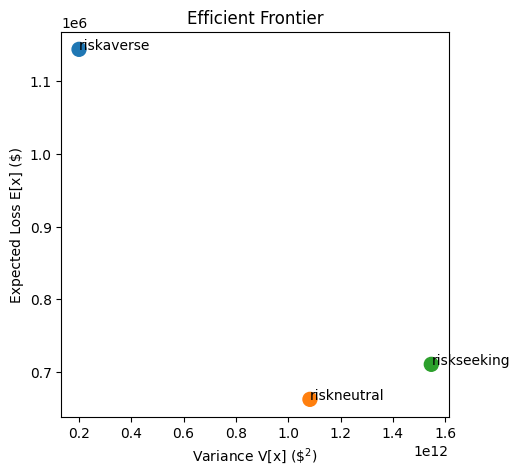

In [11]:
%%py
colors=plt.rcParams['axes.prop_cycle'].by_key()['color'][0:3]
ax=df.plot.scatter(x='v',y='e',figsize=(5,5),title='Efficient Frontier',c=colors,s=100)
[ax.annotate(x,(y,z)) for x,y,z in zip(df['lam'],df['v'],df['e'])]
plt.xlabel(r'Variance V[x] ($\$^2$)')
plt.ylabel(r'Expected Loss E[x] ($)')
plt.show()

# Trajectory and Trade List
Focusing now on the trading, Almgren and Chriss note that selling an
initial quantity $X$ over $N$ periods exhibits the following
*trajectory* along each $t_j$ as well as a *trade* list.

## Trajectory
$$
x_j = \frac{\sinh\left(\kappa\left(T-t_j\right)\right)}{\sinh(\kappa T)} X, \qquad j = 0,\dotsc,N
$$

In [12]:
trajectory:{[eta;sig;T;N;X;lam]
 tau:T%N;
 kap:csqrt lam*sig*sig%eta;
 x:csinh kap*\:T-tau*til N+1;
 x:X*first each cdiv[;csinh kap*T] each flip x;
 x}

## Trajectory plot

In [13]:
trj:trajectory[eta;sig;T;N;X] each lam
.pykx.set[`df] .pykx.topd flip trj

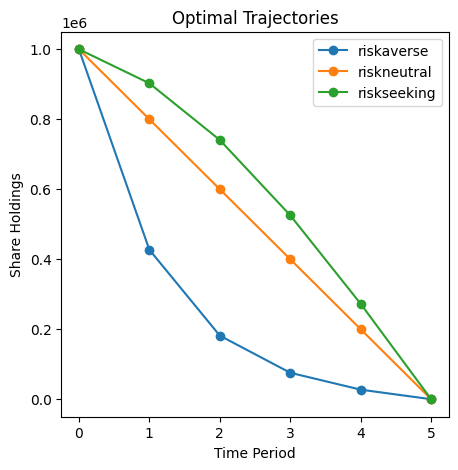

In [14]:
%%py
ax=df.plot(figsize=(5,5),title='Optimal Trajectories',style='o-')
plt.xlabel('Time Period')
plt.ylabel('Share Holdings')
plt.show()

## Trade list
$$
n_j = \frac{2\sinh\left(\tfrac{1}{2}\kappa\tau\right)}{\sinh\left(\kappa T\right)} \cosh\left(\kappa \left(T-t_{j-\tfrac{1}{2}}\right)\right)X, \qquad j = 1,\dotsc,N
$$

In [15]:
trades:{[eta;sig;T;N;X;lam]
 tau:T%N;
 kap:csqrt lam*sig*sig%eta;
 n:ccosh kap*\:T-tau*.5+til N;
 n:2*X*first each cmul[cdiv[csinh .5*kap*tau;csinh kap*T]] each flip n;
 n}

## Trade list plot

In [16]:
trd:trades[eta;sig;T;N;X] each lam
.pykx.set[`df]  .pykx.topd flip trd

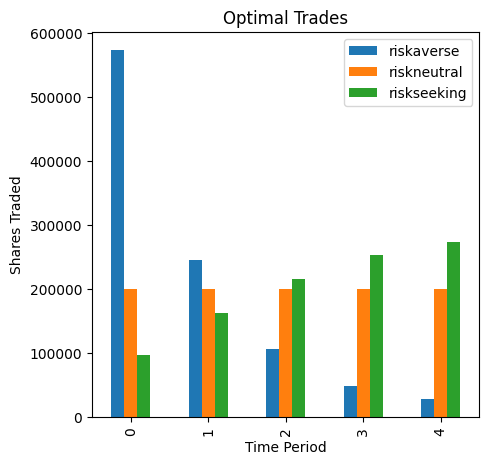

In [17]:
%%py
ax=df.plot.bar(figsize=(5,5),title='Optimal Trades')
plt.xlabel('Time Period')
plt.ylabel('Shares Traded')
plt.show()